# Image Generation with GANs


# 1.  GANs to Generate Grayscale Images of Clothing Items

## 1.1. Training Samples and the Discriminator
First, let's download the Fashion MNIST data directly from Torchvision datasets, as you did in Chapter 2. 

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42)
transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])

In [17]:
train_set=torchvision.datasets.FashionMNIST(
    root="./data/",
    train=True,
    download=True,
    transform=transform) 

In [18]:
batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)

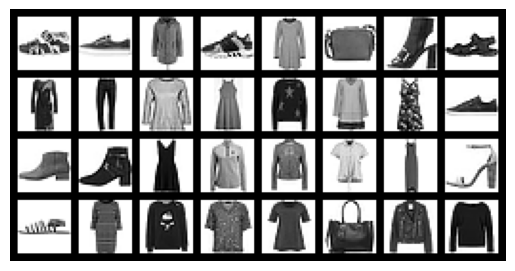

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))
# Plot all the images of the 1st batch in grid
grid = make_grid(0.5-images/2, 8, 4)
plt.imshow(grid.numpy().transpose((1, 2, 0)),
          cmap="gray_r")
plt.axis("off")
plt.show()

In [20]:
import torch
import torch.nn as nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
# the discriminator D is a binary classifier
D=nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

## 1.2	A Generator to Create Grayscale Images

In [21]:
G=nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784),
    nn.Tanh()).to(device)

In [22]:
loss_fn=nn.BCELoss()
lr=0.0001
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

## 1.3	Train GANs to Generate Images of Clothing Items

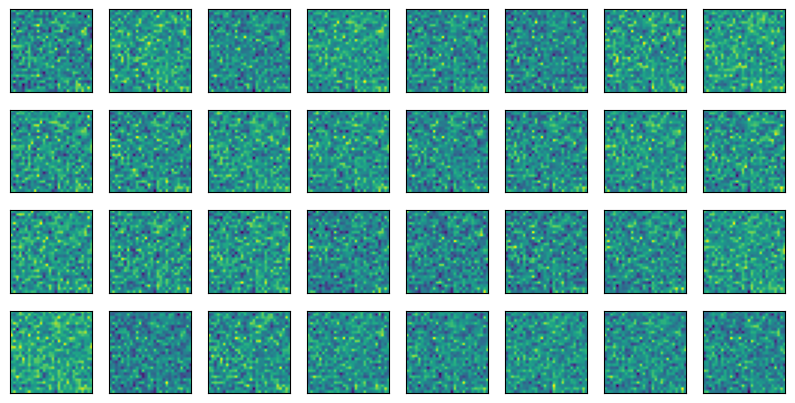

In [23]:
import matplotlib.pyplot as plt

def see_output():
    noise=torch.randn(32,100).to(device=device)
    fake_samples=G(noise).cpu().detach()    #A
    plt.figure(dpi=100,figsize=(10,5))
    for i in range(32):
        ax=plt.subplot(4, 8, i + 1)    #B
        img=(fake_samples[i]/2+0.5).reshape(28, 28)
        plt.imshow(img)    #C
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
see_output()    #D     

In [24]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

In [25]:
def train_D_on_real(real_samples):
    #r=torch.FloatTensor(real_samples)
    r=real_samples.reshape(-1,28*28).to(device)
    out_D=D(r)    
    labels=torch.ones((r.shape[0],1)).to(device)
    loss_D=loss_fn(out_D,labels)    
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()    
    return loss_D

In [26]:
def train_D_on_fake():        
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [27]:
def train_G(): 
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

at epoch 10, dloss: 0.757154643535614, gloss 1.935054063796997


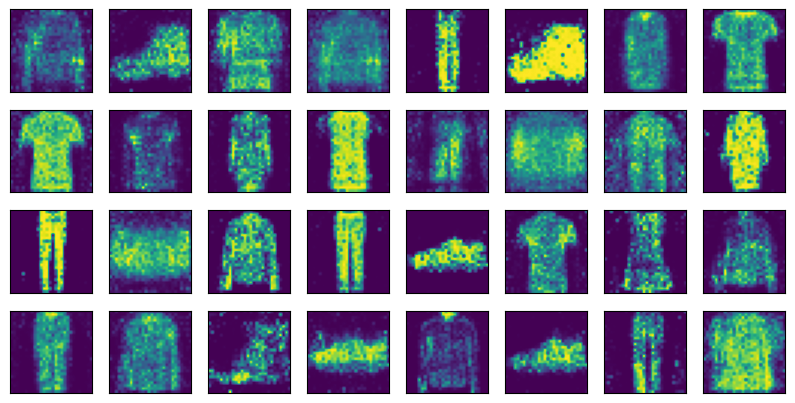

at epoch 20, dloss: 1.0754191875457764, gloss 1.1904656887054443


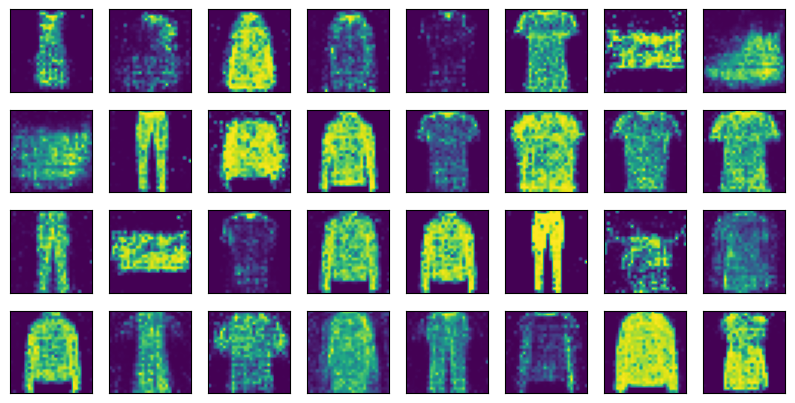

at epoch 30, dloss: 1.173140048980713, gloss 1.0069867372512817


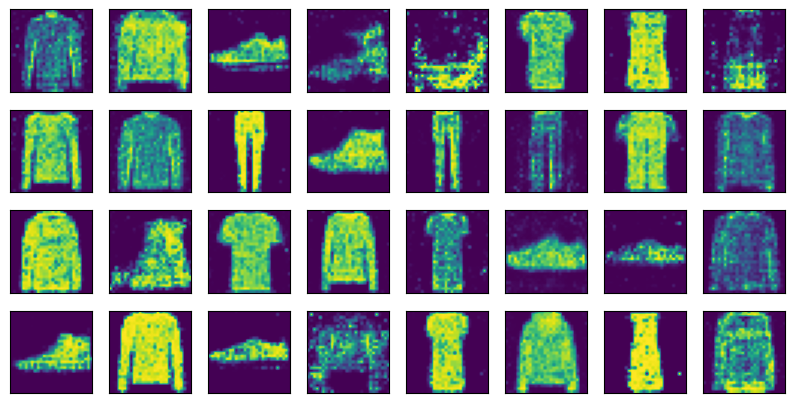

at epoch 40, dloss: 1.2080575227737427, gloss 0.9479838013648987


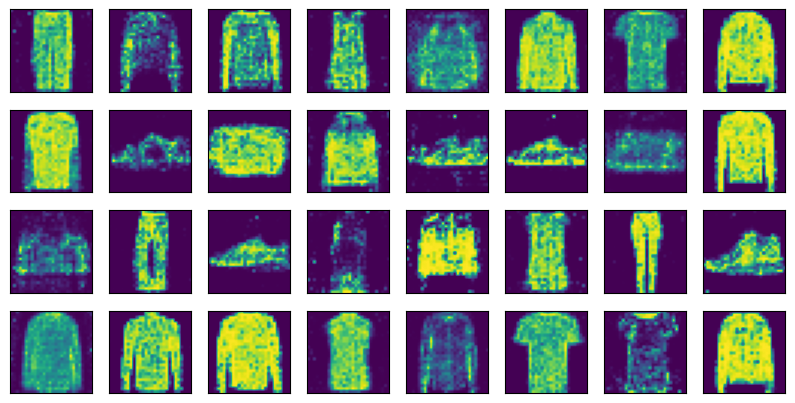

at epoch 50, dloss: 1.227891206741333, gloss 0.9168574213981628


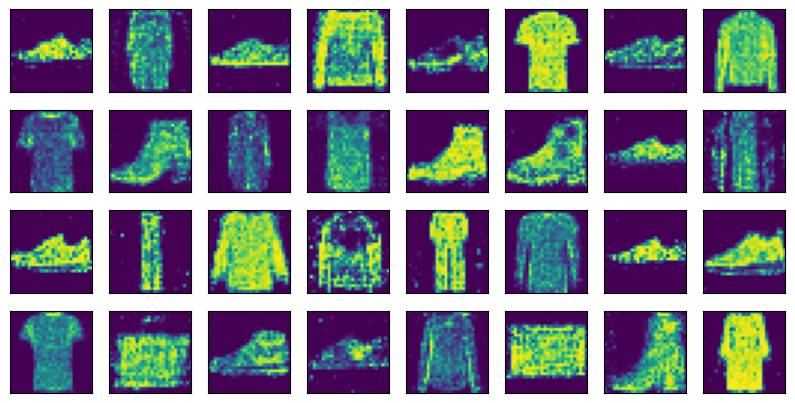

In [28]:
for i in range(50):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n    
    if i % 10 == 9:
        print(f"at epoch {i+1}, dloss: {dloss}, gloss {gloss}")
        see_output()

In [29]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
import os
os.makedirs("files", exist_ok=True)
scripted.save('files/fashion_gen.pt') 

In [30]:
new_G=torch.jit.load('files/fashion_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Tanh)
)

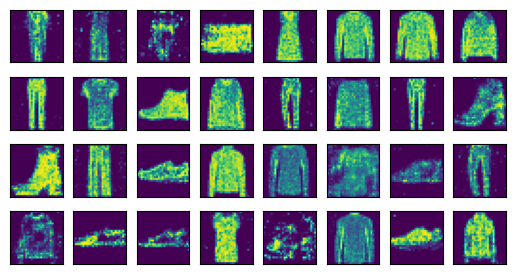

In [31]:
noise=torch.randn(batch_size,100).to(device=device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((fake_samples[i]/2+0.5).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

# 2	Convolutional Layers 
## 2.1	How do convolutional operations work?

In [32]:
import torch
torch.manual_seed(42)

img = torch.Tensor([[1,1,1],
                    [0,1,2],
                    [8,7,6]]).reshape(1,1,3,3)    

In [33]:
import torch.nn as nn

conv=nn.Conv2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=1)    #A
sd=conv.state_dict()    #B
print(sd)

OrderedDict([('weight', tensor([[[[ 0.3823,  0.4150],
          [-0.1171,  0.4593]]]])), ('bias', tensor([-0.1096]))])


In [34]:
weights={'weight':torch.tensor([[[[1,2],
   [3,4]]]]), 'bias':torch.tensor([0])}    #A
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    #B
print(conv.state_dict())    

OrderedDict([('weight', tensor([[[[1., 2.],
          [3., 4.]]]])), ('bias', tensor([0.]))])


In [35]:
output = conv(img)
print(output)

tensor([[[[ 7., 14.],
          [54., 50.]]]], grad_fn=<ConvolutionBackward0>)


## 2.2	How do stride and padding affect convolutional operations?

In [36]:
conv=nn.Conv2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2,    #A
            padding=1)    #B
sd=conv.state_dict()
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])
output = conv(img)
print(output)

tensor([[[[ 4.,  7.],
          [32., 50.]]]], grad_fn=<ConvolutionBackward0>)


# 3	Transposed Convolution and Batch Normalization
## 3.1	How do transposed convolutional layers work?

In [37]:
img = torch.Tensor([[1,0],
                    [2,3]]).reshape(1,1,2,2)

In [38]:
transconv=nn.ConvTranspose2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2)    #A
sd=transconv.state_dict()
weights={'weight':torch.tensor([[[[2,3],
   [4,5]]]]), 'bias':torch.tensor([0])}
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    #B

In [39]:
transoutput = transconv(img)
print(transoutput)

tensor([[[[ 2.,  3.,  0.,  0.],
          [ 4.,  5.,  0.,  0.],
          [ 4.,  6.,  6.,  9.],
          [ 8., 10., 12., 15.]]]], grad_fn=<ConvolutionBackward0>)


## 3.2	Batch Normalization

In [40]:
torch.manual_seed(42)    #A 
img = torch.rand(1,3,64,64)    #B
conv = nn.Conv2d(in_channels=3,
            out_channels=3,
            kernel_size=3, 
            stride=1,
            padding=1)    #C
out=conv(img)    #D
print(out.shape)

torch.Size([1, 3, 64, 64])


In [41]:
for i in range(3):
    print(f"mean in channel {i} is", out[:,i,:,:].mean().item())
    print(f"std in channel {i} is", out[:,i,:,:].std().item())

mean in channel 0 is -0.37667763233184814
std in channel 0 is 0.17841289937496185
mean in channel 1 is -0.3910464644432068
std in channel 1 is 0.16061744093894958
mean in channel 2 is 0.39275869727134705
std in channel 2 is 0.18207983672618866


In [42]:
norm=nn.BatchNorm2d(3)
out2=norm(out)
print(out2.shape)
for i in range(3):
    print(f"mean in channel {i} is", out2[:,i,:,:].mean().item())
    print(f"std in channel {i} is", out2[:,i,:,:].std().item())

torch.Size([1, 3, 64, 64])
mean in channel 0 is -1.0291114449501038e-07
std in channel 0 is 0.9999650120735168
mean in channel 1 is -9.313225746154785e-09
std in channel 1 is 0.9999282956123352
mean in channel 2 is -1.5366822481155396e-07
std in channel 2 is 0.9999712705612183


# 4	GANs to Generate Color Images of Anime Faces
## 4.1	Download Anime Faces

In [48]:
# download data from https://www.kaggle.com/datasets/splcher/animefacedataset
# modify the path based on where you saved the training data
anime_path = r"./data/anime"

In [49]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

transform = T.Compose([T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_data = ImageFolder(root=anime_path,
                         transform=transform)

In [50]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(dataset=train_data, 
               batch_size=batch_size, shuffle=True)

## 4.2. Channels First Color Images

In [51]:
image0, _ = train_data[0]
print(image0.shape)

torch.Size([3, 64, 64])


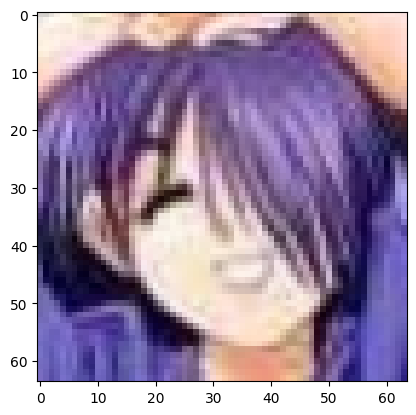

In [52]:
import matplotlib.pyplot as plt

plt.imshow(image0.permute(1,2,0)*0.5+0.5)
plt.show()

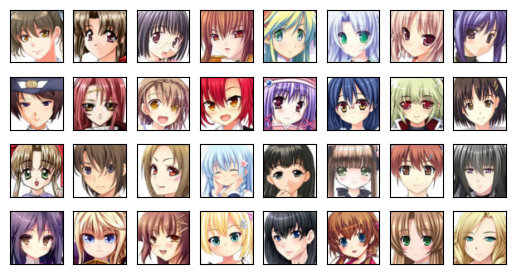

In [53]:
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(imgs[i].permute(1,2,0)/2+0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()  

imgs, _ = next(iter(train_loader))
plot_images(imgs)

# 5	Building a Deep Convolutional GAN (DCGAN) 

## 5.1. A Discriminator in DCGAN

In [54]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
D = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    nn.Flatten()).to(device)

## 5.2	Creating A Generator in DCGAN

In [55]:
G=nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()).to(device)

In [56]:
loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(G.parameters(), 
                         lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(D.parameters(), 
                         lr = lr, betas=(0.5, 0.999))

# 6. Train and Use DCGAN

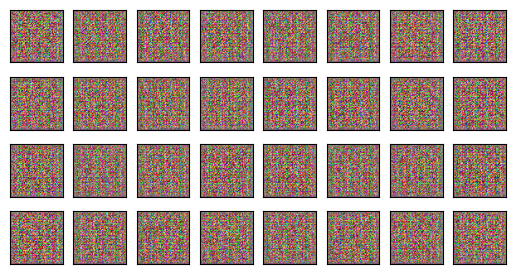

In [57]:
def test_epoch():
    noise=torch.randn(32,100,1,1).\
        to(device=device)    #A
    fake_samples=G(noise).cpu().detach()    #B
    for i in range(32):    #C
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).\
            permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()
test_epoch()    #D     

In [58]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

In [59]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    preds=D(real_samples)
    labels=torch.ones((real_samples.shape[0],1)).to(device)
    loss_D=loss_fn(preds,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D  

In [60]:
def train_D_on_fake():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D 

In [61]:
def train_G():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G   

epoch 1, dloss: 0.5902420282363892, gloss 6.635870933532715


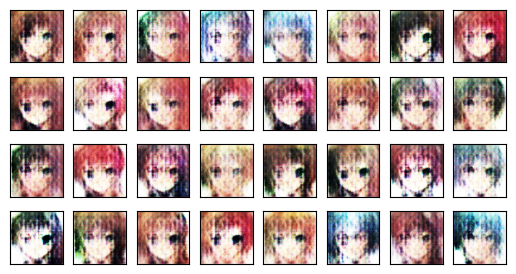

epoch 2, dloss: 0.42781147360801697, gloss 7.029567241668701


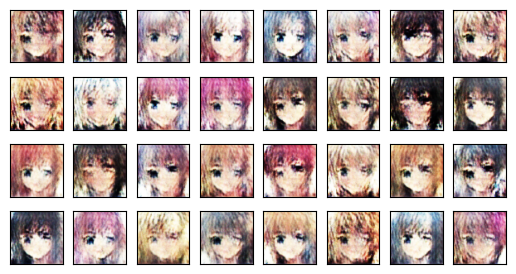

epoch 3, dloss: 0.4052537679672241, gloss 7.0447516441345215


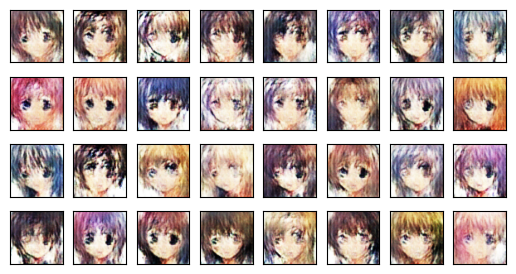

epoch 4, dloss: 0.31644877791404724, gloss 7.197377681732178


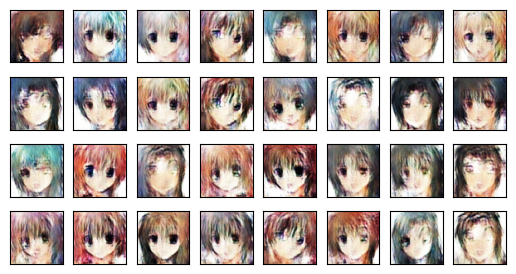

epoch 5, dloss: 0.32242271304130554, gloss 7.410675048828125


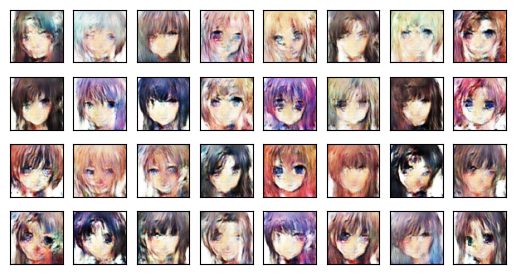

epoch 6, dloss: 0.31814464926719666, gloss 7.356553554534912


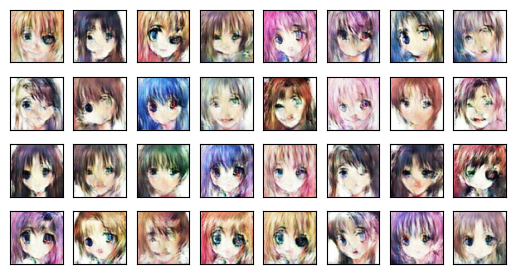

epoch 7, dloss: 0.34969648718833923, gloss 7.321345329284668


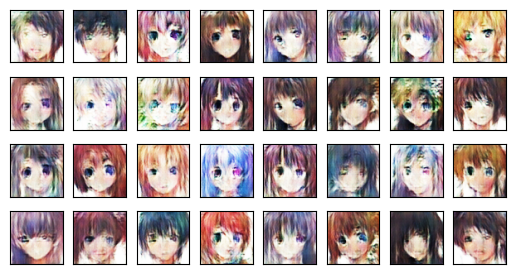

epoch 8, dloss: 0.2969801127910614, gloss 6.991220474243164


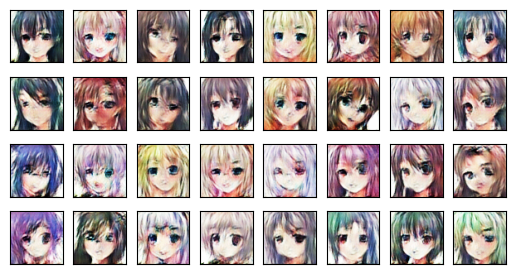

epoch 9, dloss: 0.29841476678848267, gloss 6.875115871429443


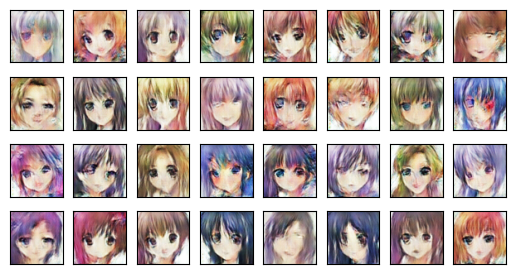

epoch 10, dloss: 0.2782871127128601, gloss 6.556215763092041


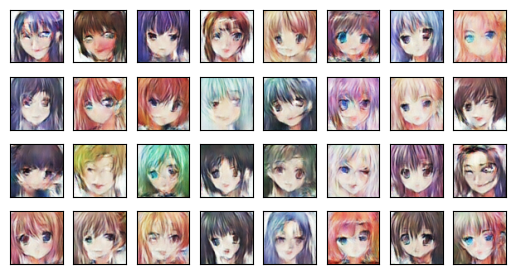

epoch 11, dloss: 0.3228936493396759, gloss 6.486862659454346


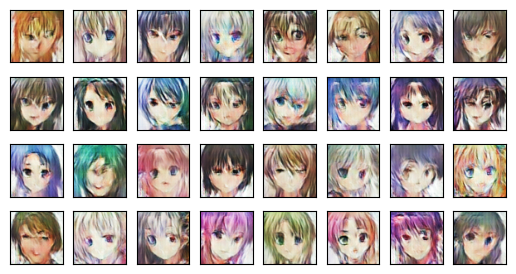

epoch 12, dloss: 0.2294970601797104, gloss 6.307359218597412


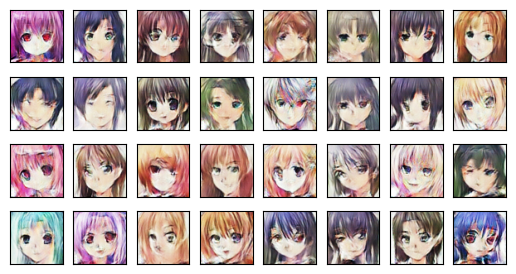

epoch 13, dloss: 0.37220698595046997, gloss 6.5001349449157715


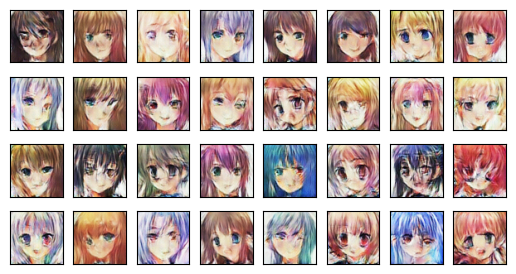

epoch 14, dloss: 0.2765112519264221, gloss 6.140195369720459


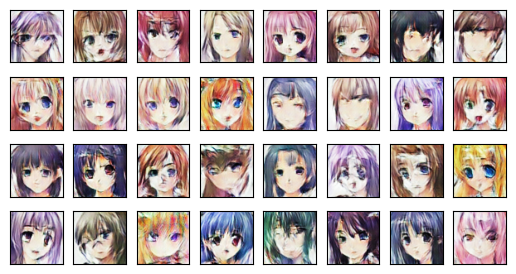

epoch 15, dloss: 0.29943981766700745, gloss 6.233016014099121


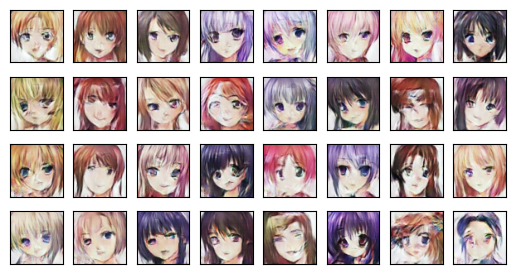

epoch 16, dloss: 0.28411611914634705, gloss 6.032069683074951


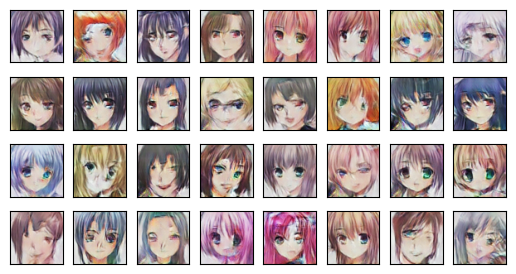

epoch 17, dloss: 0.2968672215938568, gloss 6.254895210266113


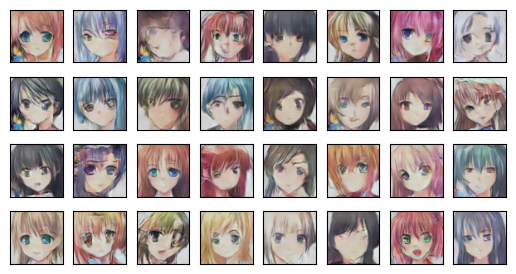

epoch 18, dloss: 0.2697233259677887, gloss 5.891319274902344


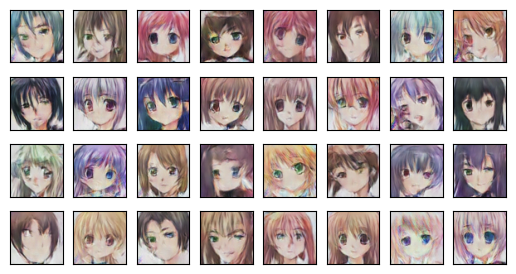

epoch 19, dloss: 0.29089704155921936, gloss 5.925175666809082


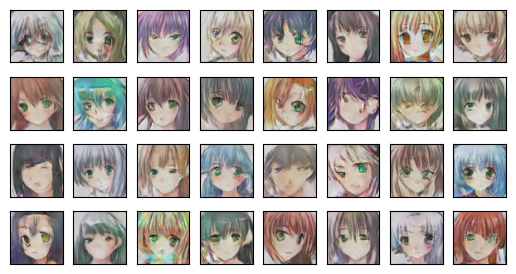

epoch 20, dloss: 0.3138677775859833, gloss 5.83304500579834


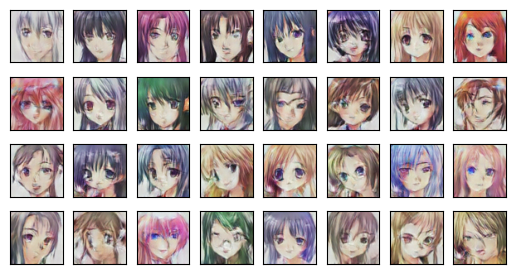

In [62]:
for i in range(20):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):    
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n
    print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")
    test_epoch()

In [63]:
# Export to TorchScript
scripted = torch.jit.script(G) 
scripted.save('files/anime_gen.pt') 

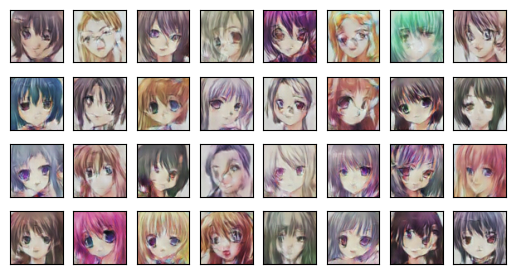

In [64]:
new_G=torch.jit.load('files/anime_gen.pt',
                     map_location=device)
new_G.eval()
noise=torch.randn(32,100,1,1).to(device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

In [65]:
# exercise 4.1
D=nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(200, 1),
    nn.Sigmoid()).to(device)

In [66]:
# exercise 4.2
G=nn.Sequential(
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 784),
    nn.Tanh()).to(device)

exercise 4.3

When the filter bottom right corner of the image, the covered area has values [[1, 2], [7, 6]]. The filter has values [[1,2],[3,4]]. The convolution operation finds the sum of the element-wise multiplication of the two tensors. Therefore, the output from scanning the bottom right corner is:
1*1+2*2+7*3+6*4=50.

In [ ]:
# exercise 4.4
import torch
from torch import nn

img = torch.Tensor([[10,10],
                    [15,20]]).reshape(1,1,2,2)

transconv=nn.ConvTranspose2d(in_channels=1,
            out_channels=1,
            kernel_size=2, 
            stride=2)    
sd=transconv.state_dict()
weights={'weight':torch.tensor([[[[2,3],
   [4,5]]]]), 'bias':torch.tensor([0])}
for k in sd:
    with torch.no_grad():
        sd[k].copy_(weights[k])    

transoutput = transconv(img)
print(transoutput)
